In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.utils import *

from ch_est_net.nets import *
from ch_est_net import Trainer

from torch.fft import fft, ifft, fftshift, ifftshift
from ch_est_net import activation

%load_ext autoreload
%autoreload 2

import torch
print(torch.__version__)

import wandb
USE_WANDB = False

/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        lista_beam_net.pt  output.svg        torchvix-sample
config_beams.yaml  model_image        __pycache__/      torchvix-sample.png
config.yaml        model_image.png    README.md         wandb/
data.h5            Notebooks/         requirements.txt  zero_150.pt
DMRS_signal/       one.pt             results/          zero.pt
1.10.1


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


In [26]:
d_re, d_im, id_re, id_im = DFT_matrixes(512,512,True)
IDFT = id_re + 1j* id_im 
DFT = d_re + 1j*d_im

DFT = DFT[:48,:512]
IDFT = DFT.conj().T


In [27]:
class Lista_Layer(torch.nn.Module):
    def __init__(self, activation_class):
        super(Lista_Layer, self).__init__()

        self.activation = getattr(ch_est_net.activation, activation_class)()
        self.theta = nn.ParameterList([])

        for param_value in self.activation.get_default_values():
            param = nn.Parameter(torch.tensor(param_value))
            self.theta.append(param)
        
        self._is_pass = False
    
    def forward(self, x_hat, v,y,A,B):
        if self._is_pass == False:
            M = torch.tensor(A.shape[0])
            r = x_hat + B@v
            sigma = torch.tensor(1.0)
            x_hat = self.activation(r, sigma, *self.theta)
            v = y - A@x_hat

        return x_hat, v 
    
    def setTrainable(self, state: bool):
        if state == True:
            # TODO delete workaround for Sst activation
            if isinstance(self.activation, ch_est_net.activation.Scaled_soft_threshold):
                for num, param in enumerate(self.theta):
                    if num != 0:
                        param.requires_grad = True    
            else:
                for param in self.theta:
                    param.requires_grad = True

        else:
            for param in self.theta:
                param.requires_grad = False
                param.grad = None

#================================================================================================

class LISTA(torch.nn.Module):
    def __init__(self, A, activation_class, layers, delta = 1.0):
        super(LISTA, self).__init__()

        self.net = torch.nn.ModuleList(
            [Lista_Layer(activation_class) for _ in range(layers)]
        )

        self.A = A 
        self.B = A.conj().T
        self.M, self.N = torch.tensor(A.shape[0]), torch.tensor(A.shape[1])
        self.delta = delta 

        assert self.M <= self.N , 'M assumed to be <= N'        

        self.layers = layers
        self.log_dict = {}
    
    def forward(self, y, save_log = False):
        y = y.T 
        self.maximum = torch.linalg.vector_norm(y, ord = float('inf'))
        y = self.delta * y/self.maximum

        x_hat = torch.zeros(self.N, y.shape[1], dtype = self.A.dtype)
        v = y

        assert list(x_hat.shape) == [512,64], 'Size is {0}'.format(list(x_hat.shape))
        assert list(v.shape) == [48,64], 'Size is {0}'.format(list(v.shape))

        for num, layer in enumerate(self.net):
            x_hat,v, = layer.forward(x_hat,v,y,self.A, self.B)
            if save_log: self.save_log(num=num, x_hat = x_hat,v=v)
        x =self.A @ x_hat
        x = x*self.maximum/self.delta
        return x.T
    

    def save_log(self, num:int, **kwargs) -> None:
        if num == 0:
            self.log_dict.clear()

        with torch.no_grad():
            for key, value in kwargs.items():    
                if key not in self.log_dict: 
                    self.log_dict[key] = []    
                self.log_dict[key].append(value)


    def setState(self, trainable_code, pass_code) -> None:
        c = [bool(int(d)) for d in str(trainable_code)]
        p = [bool(int(d)) for d in str(pass_code)]

        for i, module in enumerate(self.net):
            module.setTrainable(c[i])
            module._is_pass = p[i]

    def set_from_prev_layer(self, layer:int):
        state = self.net[layer-1].state_dict()
        self.net[layer].load_state_dict(state)    

#==================================================================================================
#==================================================================================================
#==================================================================================================

class Tied_LAMP_Layer(torch.nn.Module):
    def __init__(self, activation_class):
        super(Tied_LAMP_Layer,self).__init__()
        
        self.activation = getattr(ch_est_net.activation, activation_class)()

        self.theta = nn.ParameterList([])
        
        for param_value in self.activation.get_default_values():
            param = nn.Parameter(torch.tensor(param_value))
            self.theta.append(param)
        
        self._is_pass = False
    
    def forward(self, x_hat, v, y, A, B):
        if self._is_pass == False:
            M = torch.tensor(A.shape[0])
            r = x_hat + B@v
            sigma = 1.0/torch.sqrt(M) * torch.linalg.vector_norm(v, ord=0, dim =0)

            x_hat = self.activation(r, sigma, *self.theta)
            b = 1/M * torch.sum(self.activation.derivative(r,sigma, *self.theta), dim = 0)
            v = y - A@x_hat + b*v
        
        return x_hat, v 

    def setTrainable(self, state: bool):
        if state == True:
            # TODO delete workaround for Sst activation
            if isinstance(self.activation, ch_est_net.activation.Scaled_soft_threshold):
                for num, param in enumerate(self.theta):
                    if num != 0:
                        param.requires_grad = True    
            else:
                for param in self.theta:
                    param.requires_grad = True

        else:
            for param in self.theta:
                param.requires_grad = False
                param.grad = None

#============================================================================================

class Tied_LAMP(torch.nn.Module):
    def __init__(self, A, activation_class, layers:int, delta=1.0):
        super(Tied_LAMP, self).__init__()

        self.net = torch.nn.ModuleList(
            [Tied_LAMP_Layer(activation_class) for _ in range(layers)]
        )

        self.A = A
        self.B = nn.Parameter(torch.clone(A).conj().T.detach(), requires_grad = True)
        self.M, self.N = torch.tensor(A.shape[0]), torch.tensor(A.shape[1])
        self.delta = delta 

        assert self.M <= self.N , 'M assumed to be <= N'

        self.layers = layers
        #self.is_save_log = False
        self.log_dict = {}
    
    def forward(self, y, save_log = False):
        y = y.T

        self.maximum = torch.linalg.vector_norm(y,ord = float('inf'))
        y = self.delta * y/self.maximum 

        x_hat = torch.zeros(self.N, y.shape[1], dtype = self.A.dtype)
        v = y

        assert list(x_hat.shape) == [512,64], 'Size is {0}'.format(list(x_hat.shape))
        assert list(v.shape) == [48,64], 'Size is {0}'.format(list(v.shape))

        for num, layer in enumerate(self.net):
            x_hat,v = layer.forward(x_hat,v,y,self.A, self.B)

            if save_log: self.save_log(num=num, x_hat=x_hat, v=v)
        
        x = self.A@x_hat
        x = x*self.maximum/self.delta

        return x.T


    def save_log(self, num:int, **kwargs) -> None:
        if num == 0:
            self.log_dict.clear()

        with torch.no_grad():
            for key, value in kwargs.items():    
                if key not in self.log_dict: 
                    self.log_dict[key] = []    
                self.log_dict[key].append(value)


    def setState(self, trainable_code, pass_code) -> None:
        c = [bool(int(d)) for d in str(trainable_code)]
        p = [bool(int(d)) for d in str(pass_code)]

        for i, module in enumerate(self.net):
            module.setTrainable(c[i])
            module._is_pass = p[i]

    def set_from_prev_layer(self, layer:int):
        state = self.net[layer-1].state_dict()
        self.net[layer].load_state_dict(state)    


In [3]:
def get_batch(snr_range, ind_range, seed):
    '''
    For files ind_range add noise with snr_range and stack all realizations to single array
    --------------------------------------------------------------------------
    RETURNS:
    pilot_batch -> [Realizations ; Antennas ; Subc ; Re/Im ]
    data_batch  -> [Realizations ; Antennas ; Subc ; 12? ; Re/Im]
    pilot_batch -> [Realizations]
    --------------------------------------------------------------------------
    Realizations = len(snr_range)*len(ind_range) 
    '''

    pilot_batch = torch.tensor(())
    pilot_noisy_batch = torch.tensor(())
    data_batch = torch.tensor(())
    noise_P_batch = torch.tensor(())

    for snr in snr_range:
        for ind in ind_range:
            h_pilot, h_data = data_load(scen0, dtype = dtype, onePilotFolder = onePilotFolder,dataL=dataL, ind = ind) 
                                                  # load data
            h_pilot_noisy, _ = add_noise(h_pilot, SNR = snr,scen=scen0, dtype=dtype, seed = seed)                             # add noise to pilots
            h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = snr, dtype = dtype, seed = seed)     # add noise to data

            h_pilot = h_pilot.mean(dim = 2).unsqueeze(dim = 0)                                  # mean over pilots dim and add aditional dim
            h_pilot_noisy = h_pilot_noisy.mean(dim = 2).unsqueeze(dim = 0)

            h_data_noisy = h_data_noisy.unsqueeze(dim = 0)                                      # add additional dim for
            data_noise_power = data_noise_power.unsqueeze(dim =0)

            pilot_batch = torch.cat((pilot_batch, h_pilot), dim = 0)

            pilot_noisy_batch = torch.cat((pilot_noisy_batch, h_pilot_noisy), dim = 0)
            data_batch = torch.cat((data_batch, h_data_noisy), dim = 0)
            noise_P_batch = torch.cat((noise_P_batch, data_noise_power), dim = 0)

    return pilot_batch, pilot_noisy_batch, data_batch, noise_P_batch


# x_batch, u_batch, _, _ = get_batch(snr_range = [-12, -8, -6 , -3 ,0],
#                                             ind_range = range(1, 140, 3),
#                                             seed = 3)

x_batch, u_batch, _, _ = get_batch(snr_range = [ -6, -5, -4, -3 ,-2, -1 ,0],
                                            ind_range = [85],
                                            seed = 3)



x_test, u_test, _, _ = get_batch(snr_range = [-10, -9, -5 , -2 , -1],
                                              ind_range = range(2, 141, 3),
                                              seed = 2)

x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

x_test = x_test[:,:,:,0] + 1j*x_test[:,:,:,1]
u_test = u_test[:,:,:,0] + 1j*u_test[:,:,:,1]


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Scen_Trainer():
    def __init__(self, model, criterion, watcher = None):
        self.model = model
        self.criterion = criterion    

        self.scenary = self.gen_scenary(model.layers)
        self.pass_scenary = self.gen_pass_scenary(model.layers)
        self.watcher = watcher
        self.train_loss_history = []
        self.test_loss_history = []
        

    def train(self, clear_data, noisy_data, clear_test, noisy_test ,  epochs, device = 'cpu'):
        self.model.to(device)

        previous_loss_value = 0
        degrade_counter = 0

        for epoch in range(epochs):
            self.model.train()
            current_mse = torch.tensor(0.0, dtype= torch.float64)
            test_mse = torch.tensor(0.0, dtype= torch.float64)
            
            self.optimizer.zero_grad()

            for cur_data_idx in range(clear_data.shape[0]):
                x = clear_data[cur_data_idx,:].type(torch.complex64).detach()
                y = noisy_data[cur_data_idx,:].type(torch.complex64).detach()

                x_hat = self.model(y)
                current_mse += self.criterion(x,x_hat)
            
            current_mse.backward()
            self.optimizer.step()
            self.train_loss_history.append(current_mse.detach().item())

            # -------------TESTING------------- 
            self.model.eval()
            with torch.no_grad():
                for cur_data_idx in range(clear_test.shape[0]):
                    
                    #if epoch%5==0:
                    #    if cur_data_idx == 0:
                    #        self.model.is_save_log = True

                    x = clear_test[cur_data_idx,:].type(torch.complex64).detach()
                    y = noisy_test[cur_data_idx,:].type(torch.complex64).detach()

                    #if epoch%5==0:
                    #    if cur_data_idx == 0:
                    #        res = self.model(y, True)
                    #else:
                    res = self.model(y)

                    test_mse += self.criterion(x, res)
                

            self.test_loss_history.append(test_mse.item())
            if epoch%5 == 0:
                print('Epoch: {0}. Train Loss : {1:9.5f}. Test Loss: {2:9.5f}'.format(epoch,current_mse.item(), test_mse.item()))

            if self.scheduler.optimizer.param_groups[0]['lr'] < 1e-4:
                break
            
            if test_mse.item() > previous_loss_value:
                degrade_counter += 1

                #if degrade_counter > 50:
                #    break
            
            elif degrade_counter > 0:
                degrade_counter -=1

            previous_loss_value = current_mse.item()
            
            self.scheduler.step(test_mse.detach().item())
            


    def train_with_scenary(self, clear_data, noisy_data, clear_test, noisy_test, epochs):
        for i in range(0, len(self.scenary)):
            print('\n', '======================================')
            print('\n', 'Stage ', i)

            if i == 0:
                self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1.0e-2)
            else:
                self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1.0e-3)

            self.scheduler = ReduceLROnPlateau(
                                        optimizer = self.optimizer,
                                        mode = 'min',
                                        factor = 0.1,
                                        patience = 10,
                                        threshold = 1e-3,
                                        threshold_mode = 'rel',
                                        cooldown = 10,
                                        min_lr = 1e-5 
            )

            if i%2==1:
                n = int((i+1)/2)
                self.model.set_from_prev_layer(n)
            
            self.model.setState(self.scenary[i], self.pass_scenary[i])
            self.train(clear_data, noisy_data, clear_test, noisy_test ,  epochs)

        print("===========================================================")
        print("===========================================================")
        print("DONE")



    def bin_to_dec(self, bin_str):
            if type(bin_str == str):
                return  int(bin_str , 2) 
            return -1


    def dec_to_bin(self, dec_val):
        return bin(dec_val)[2:]


    def gen_scenary(self, n_layers):
        n_zeros = n_layers - 1
        start_value = '1'
        end_value = '1'

        start_value += '0' * n_zeros
        end_value += '1' * n_zeros

        scenary = []

        current_dec = self.bin_to_dec(start_value)
        scenary.append(start_value)

        first_dec = self.bin_to_dec(start_value)
        second_dec = first_dec

        for i in range(1, n_layers):
            first = i*'0' + self.dec_to_bin(int(first_dec/2))
            scenary.append(first)
            first_dec = self.bin_to_dec(first)

            second_dec = second_dec + first_dec
            second = self.dec_to_bin(second_dec)
            scenary.append(second)

        return scenary


    def gen_pass_scenary(self, n_layers):
        start = '0' + '1'*(n_layers-1)
        pass_scen = []

        pass_scen.append(start)
        start_dec = self.bin_to_dec(start)

        current = start_dec
        for i in range(1, n_layers-1):
            
            start = (i+1)*'0' + self.dec_to_bin(start_dec >> 1)

            pass_scen.append(start)
            pass_scen.append(start)

            start_dec = self.bin_to_dec(start)

        end = '0' * n_layers
        pass_scen.append(end)
        pass_scen.append(end)
        return pass_scen


from torch.nn.functional import mse_loss

def MSE(x_real, x_hat):
    '''Mean squared error generalized for complex values'''

    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    
    if torch.is_complex(x_real):
        mse = torch.sum(torch.abs(x_real-x_hat)**2)/torch.numel(x_real)

    else:
        mse = mse_loss(x_real, x_hat)

    return mse


In [ ]:
lista = LISTA(DFT, 'Scaled_soft_threshold', 2, 5.0)
lamp = Tied_LAMP(DFT, 'Scaled_soft_threshold', 2, 5.0)

In [ ]:
x = u_batch[1,:].type(torch.complex64).detach()
x_out = lista(x)
x_out.shape
trainer = Scen_Trainer(lista,MSE)
trainer.train_with_scenary(x_batch, u_batch, x_test,u_test, 300)



 Stage  0
Epoch: 0. Train Loss :   0.48495. Test Loss: 169.28800
Epoch: 5. Train Loss :   0.47259. Test Loss: 165.58167
Epoch: 10. Train Loss :   0.46001. Test Loss: 161.92584
Epoch: 15. Train Loss :   0.44727. Test Loss: 158.31275
Epoch: 20. Train Loss :   0.43442. Test Loss: 154.73628
Epoch: 25. Train Loss :   0.42150. Test Loss: 151.19160
Epoch: 30. Train Loss :   0.40858. Test Loss: 147.67512
Epoch: 35. Train Loss :   0.39571. Test Loss: 144.18443
Epoch: 40. Train Loss :   0.38296. Test Loss: 140.71811
Epoch: 45. Train Loss :   0.37038. Test Loss: 137.27595
Epoch: 50. Train Loss :   0.35802. Test Loss: 133.85888
Epoch: 55. Train Loss :   0.34591. Test Loss: 130.46905
Epoch: 60. Train Loss :   0.33411. Test Loss: 127.10978
Epoch: 65. Train Loss :   0.32264. Test Loss: 123.78543
Epoch: 70. Train Loss :   0.31152. Test Loss: 120.50131
Epoch: 75. Train Loss :   0.30078. Test Loss: 117.26331
Epoch: 80. Train Loss :   0.29041. Test Loss: 114.07774
Epoch: 85. Train Loss :   0.28043. Tes

In [ ]:
#lamp = Tied_LAMP(DFT, 'Scaled_soft_threshold', 2, 5.0)
trainer = Scen_Trainer(lamp,MSE)
trainer.train_with_scenary(x_batch, u_batch, x_test,u_test, 1000)



 Stage  0
Epoch: 0. Train Loss :   0.17707. Test Loss:  61.82812
Epoch: 5. Train Loss :   0.05982. Test Loss:  59.18298
Epoch: 10. Train Loss :   0.04303. Test Loss:  58.79503
Epoch: 15. Train Loss :   0.03307. Test Loss:  72.79762
Epoch: 20. Train Loss :   0.02560. Test Loss:  71.03497
Epoch: 25. Train Loss :   0.02313. Test Loss:  70.95563
Epoch: 30. Train Loss :   0.02083. Test Loss:  71.56322
Epoch: 35. Train Loss :   0.01996. Test Loss:  72.75012
Epoch: 40. Train Loss :   0.01961. Test Loss:  73.20490
Epoch: 45. Train Loss :   0.01930. Test Loss:  73.10968
Epoch: 50. Train Loss :   0.01919. Test Loss:  72.99360
Epoch: 55. Train Loss :   0.01906. Test Loss:  72.85280
Epoch: 60. Train Loss :   0.01893. Test Loss:  72.71202


 Stage  1
Epoch: 0. Train Loss :   1.78471. Test Loss: 4794.57740
Epoch: 5. Train Loss :   1.56266. Test Loss: 4200.20555


KeyboardInterrupt: 

In [ ]:
lamp.net[0].theta[1]


Parameter containing:
tensor(0.9645)

In [ ]:
t3 = torch.tensor(trainer.test_loss_history)
t4 = torch.tensor(trainer.train_loss_history)

In [ ]:
t1 = torch.tensor(trainer.test_loss_history)
t2 = torch.tensor(trainer.train_loss_history)

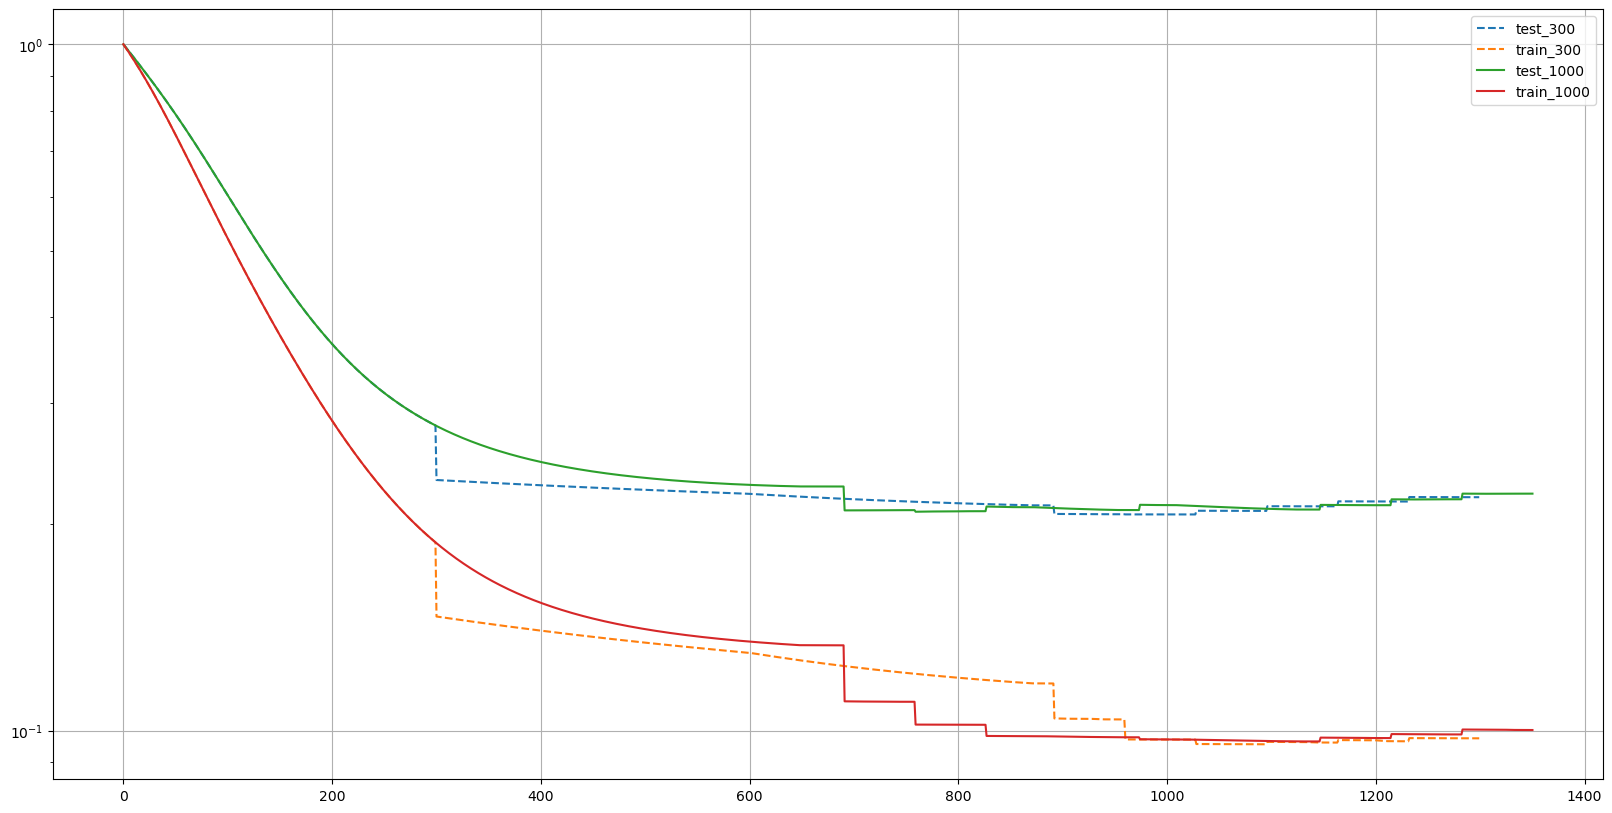

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(t1/torch.max(t1),'--', label = 'test_300')
plt.plot(t2/torch.max(t2),'--', label = 'train_300')
plt.plot(t3/torch.max(t3), label = 'test_1000')
plt.plot(t4/torch.max(t4), label = 'train_1000')

plt.legend()
plt.yscale('log')
plt.grid()

In [ ]:
lamp = Tied_LAMP(DFT,'Pwlin',4)
trainer = Scen_Trainer(lamp,MSE)

In [ ]:
trainer.train_with_scenary(x_batch, u_batch, x_test,u_test, 300)



 Stage  0
Epoch: 0. Train Loss :   0.53782. Test Loss: 224.08044
Epoch: 5. Train Loss :   0.25179. Test Loss: 119.39030
Epoch: 10. Train Loss :   0.07798. Test Loss:  69.86397
Epoch: 15. Train Loss :   0.08040. Test Loss:  81.69602
Epoch: 20. Train Loss :   0.05755. Test Loss:  65.51649
Epoch: 25. Train Loss :   0.03637. Test Loss:  58.54447
Epoch: 30. Train Loss :   0.03965. Test Loss:  60.70797
Epoch: 35. Train Loss :   0.03248. Test Loss:  59.26722
Epoch: 40. Train Loss :   0.03027. Test Loss:  59.00286
Epoch: 45. Train Loss :   0.02922. Test Loss:  58.62382
Epoch: 50. Train Loss :   0.02829. Test Loss:  58.30130
Epoch: 55. Train Loss :   0.02756. Test Loss:  58.08903
Epoch: 60. Train Loss :   0.02701. Test Loss:  57.98717
Epoch: 65. Train Loss :   0.02661. Test Loss:  57.96865
Epoch: 70. Train Loss :   0.02631. Test Loss:  57.98817
Epoch: 75. Train Loss :   0.02628. Test Loss:  57.99090
Epoch: 80. Train Loss :   0.02626. Test Loss:  57.99312
Epoch: 85. Train Loss :   0.02623. Tes

In [ ]:
# Вызов функции
SNR_range = range(-12,1,3)
scenario_range = range(1, 140, 2)

detector_error_beam_net_1, losses = get_detector_error(method= trainer.model,is_complex=True, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            ml = ml_default,
            SNR_L=SNR_range)


/home/alex/GitHub/ML_for_channel_estimation/ch_est_net/utils.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u[:,:,0] + 1j*u[:,:,1], dtype = torch.complex64)


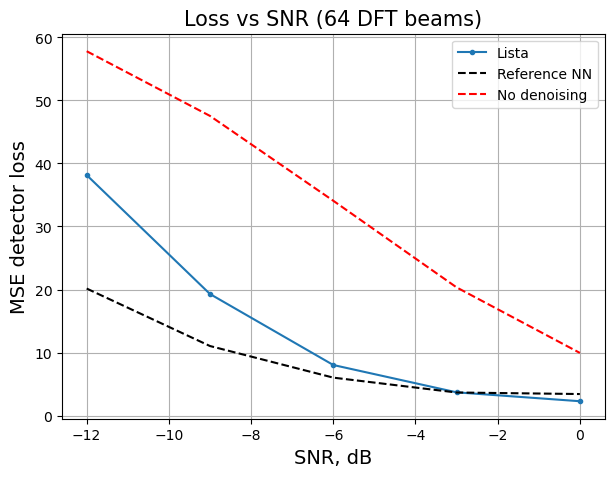

In [ ]:
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]
SNR_range = range(-12,1,3)
lista_beam_net_1 = [22.4750, 11.875, 6.335, 3.123, 2.094]
lista_beam_net_2 = [21.1612, 10.924, 6.216, 3.526, 3.194]

import matplotlib.pyplot as plt
plt.style.use("default")

plt.figure(figsize=(7,5))
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = 'Lista')
plt.plot(SNR_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (64 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
#plt.ylim([0 , 48])
plt.grid()


plt.show()

In [ ]:
d_re, d_im, id_re, id_im = DFT_matrixes(512,512,True)
IDFT = id_re + 1j* id_im 
DFT = d_re + 1j*d_im

DFT = DFT[:48,:512]
IDFT = DFT.conj().T


A = DFT
B = DFT.conj().T

In [ ]:

x_batch, u_batch, _, _ = get_batch(snr_range = [0],
                                            ind_range = [85],
                                            seed = 3)

ant = 1

x = x_batch[0,ant,:,0] + 1j*x_batch[0,ant,:,1]
u = u_batch[0,ant,:,0] + 1j*u_batch[0,ant,:,1]

u = torch.unsqueeze(u,0)
x = torch.unsqueeze(x, 0)


act = activation.Scaled_soft_threshold()

def E(x):
    return torch.sum(abs(x)**2)


In [ ]:
print(x.shape)


torch.Size([1, 48])


In [ ]:
print('noisy (freq) ',E(u))
print('noisy (time) ',E(ifft(u,n=512,dim = 1,norm ='ortho')))

x_hat = act(ifft(u,n=512,dim = 1,norm ='ortho'), 1, 0.10,1)
print('Taps (time) ',E(x_hat))
print('Taps (freq) ',E(fft(x_hat, n=48, dim=1, norm = 'ortho')))



noisy (freq)  tensor(3.3517)
noisy (time)  tensor(3.3517)
Taps (time)  tensor(0.1979)
Taps (freq)  tensor(0.0898)


In [ ]:
x_hat = torch.zeros(512,1)
x_hat1 = torch.zeros(512,1)
v = u.T
v1 = u.T

for i in range(1):
    x_hat = act(x_hat + B@v, 1 , 0.10, 1)
    v = u.T - A@x_hat

    # x_hat1 = act(x_hat + B@v, 1 , 0.10, 1)
    # v1 = u.T - A@x_hat1


In [ ]:
print('x_hat: ',torch.sum(abs(A@x_hat)**2))
print('inital: ',torch.sum(abs(u)**2))
print('residual: ',torch.sum(abs(v)**2))
torch.sum(abs(A@x_hat)**2) + torch.sum(abs(v)**2)


x_hat:  tensor(0.1513)
inital:  tensor(3.3517)
residual:  tensor(2.4746)


tensor(2.6258)

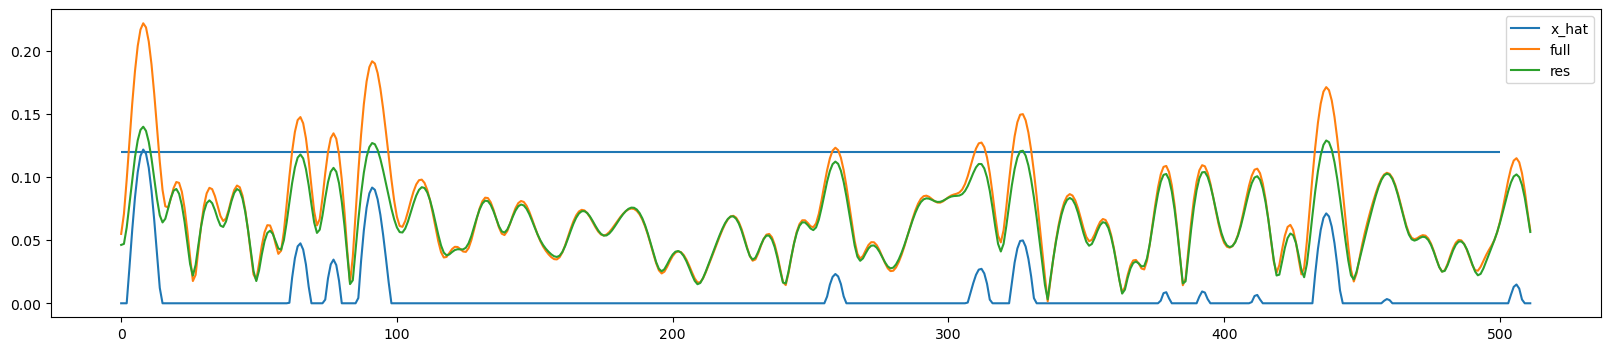

In [ ]:
plt.figure(figsize=(20,4))
plt.hlines(0.12, 0, 500)
plt.plot(abs(x_hat), label = 'x_hat')
#plt.plot(abs(x_hat1), label = 'x_hat1')
plt.plot(abs(B@u.T), label = 'full')
plt.plot(abs(B@v), label = 'res')
plt.legend()

In [ ]:
E()

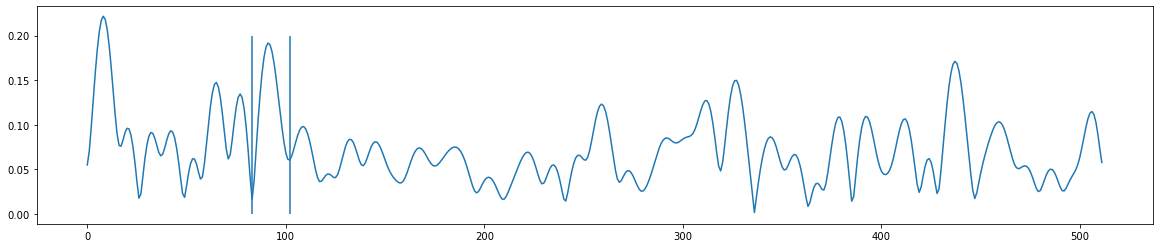

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(abs(B@u.T), label = 'x_hat')
#plt.xlim([70,110])
plt.vlines(83,0,0.2)
plt.vlines(102,0,0.2)
#peak = (B@u.T)[83:102]
peak = (B@u.T)
peak[0:83] = 0
peak[102:] = 0 


In [ ]:
x_hat = torch.zeros(512,1)
x_hat1 = torch.zeros(512,1)
v = u.T
v1 = u.T

for i in range(10000):
    x_hat = act(x_hat + B@v, 1 , 0.10, 1)
    v = u.T - A@x_hat

    # x_hat1 = act(x_hat + B@v, 1 , 0.10, 1)
    # v1 = u.T - A@x_hat1


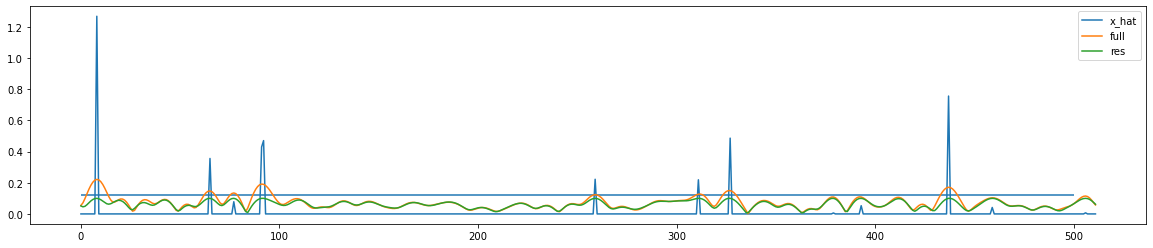

In [ ]:
plt.figure(figsize=(20,4))
plt.hlines(0.12, 0, 500)
plt.plot(abs(x_hat), label = 'x_hat')
#plt.plot(abs(x_hat1), label = 'x_hat1')
plt.plot(abs(B@u.T), label = 'full')
plt.plot(abs(B@v), label = 'res')
plt.legend()

===============================================================================================================================================

In [ ]:
x_test, u_test, _, _ = get_batch(snr_range = [-10, -9, -5 , -2 , -1],
                                              ind_range = range(2, 141, 3),
                                              seed = 2)


x_batch, u_batch, _, _ = get_batch(snr_range = [0],
                                            ind_range = [85],
                                            seed = 3)


x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

x_test = x_test[:,:,:,0] + 1j*x_test[:,:,:,1]
u_test = u_test[:,:,:,0] + 1j*u_test[:,:,:,1]

print(x_batch.shape)
print(u_batch.shape)
print(x_test.shape)
print(u_test.shape)


torch.Size([1, 64, 48])
torch.Size([1, 64, 48])
torch.Size([235, 64, 48])
torch.Size([235, 64, 48])


In [ ]:
lamp = Tied_LAMP(DFT, 'Scaled_soft_threshold', 2, 5.0)
trainer = Scen_Trainer(lamp,MSE)
trainer.train_with_scenary(x_batch, u_batch, x_test,u_test, 1000)



 Stage  0
Epoch: 0. Train Loss :   0.02044. Test Loss:  60.14511
Epoch: 5. Train Loss :   0.00617. Test Loss:  68.40736
Epoch: 10. Train Loss :   0.00443. Test Loss:  73.81775
Epoch: 15. Train Loss :   0.00376. Test Loss:  79.55568
Epoch: 20. Train Loss :   0.00323. Test Loss:  77.70012
Epoch: 25. Train Loss :   0.00291. Test Loss:  76.82743
Epoch: 30. Train Loss :   0.00280. Test Loss:  77.19680
Epoch: 35. Train Loss :   0.00274. Test Loss:  77.69475
Epoch: 40. Train Loss :   0.00273. Test Loss:  77.86637
Epoch: 45. Train Loss :   0.00270. Test Loss:  78.07512
Epoch: 50. Train Loss :   0.00268. Test Loss:  78.31456


 Stage  1
Epoch: 0. Train Loss :   0.25027. Test Loss: 6812.89637
Epoch: 5. Train Loss :   0.22687. Test Loss: 5862.35966
Epoch: 10. Train Loss :   0.20857. Test Loss: 4755.19991
Epoch: 15. Train Loss :   0.14621. Test Loss: 3828.58214
Epoch: 20. Train Loss :   0.09471. Test Loss: 3104.19675
Epoch: 25. Train Loss :   0.06468. Test Loss: 2553.57321
Epoch: 30. Train Loss 

KeyboardInterrupt: 

In [ ]:
lamp.forward(u_batch[0,:],True)

tensor([[ 1.0861e-01+0.4907j,  1.8047e-01+0.4974j,  2.6433e-01+0.4887j,
          ..., -1.1225e-01-0.4643j, -1.6879e-01-0.4378j,
         -2.2054e-01-0.3869j],
        [-1.1981e-02+0.1864j,  1.8922e-02+0.1472j,  3.3283e-02+0.1141j,
          ..., -5.9048e-02-0.0592j, -7.4639e-02-0.0438j,
         -1.1141e-01-0.0240j],
        [ 1.9209e-01-0.4641j,  1.1748e-01-0.4551j,  5.4985e-02-0.4540j,
          ..., -2.0768e-01+0.2203j, -1.9116e-01+0.1962j,
         -1.6641e-01+0.1897j],
        ...,
        [-1.4125e-02+0.0175j, -1.1457e-02+0.0157j, -1.0196e-02+0.0127j,
          ...,  7.4942e-04+0.0169j,  2.0846e-04+0.0194j,
          6.1481e-04+0.0223j],
        [ 2.8018e-01+0.0625j,  2.4529e-01+0.0050j,  1.9483e-01-0.0360j,
          ...,  6.6392e-02-0.0325j,  1.0121e-01-0.0615j,
          1.2798e-01-0.1236j],
        [ 5.1190e-02-0.0358j,  4.0232e-02-0.0414j,  2.9864e-02-0.0432j,
          ...,  2.1120e-02-0.0415j,  1.5849e-02-0.0449j,
          9.4826e-03-0.0477j]], grad_fn=<PermuteBackward0>

In [ ]:
lamp.log_dict.keys()

dict_keys(['x_hat', 'v'])

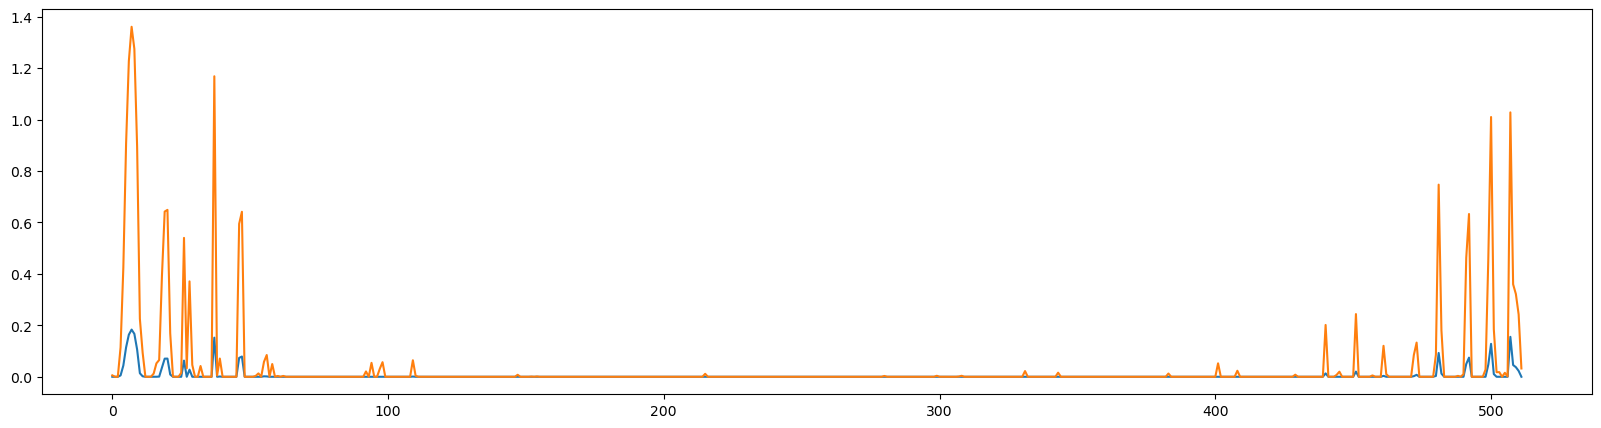

In [ ]:
plt.figure(figsize=(20,5))
g = abs(lamp.log_dict['x_hat'][0][:,1].detach().numpy())**2
plt.plot(g)
g = abs(lamp.log_dict['x_hat'][1][:,1].detach().numpy())**2
plt.plot(g)

In [ ]:
import numpy as np 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
x = np.random.randint(0,2,(10,1))
w = np.random.rand(10,1)
y = x+w 

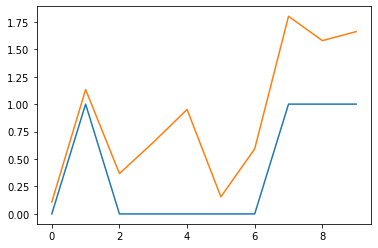

In [ ]:
plt.plot(x)
plt.plot(y)

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
mean_squared_error(x,y)

0.3279743939539732

In [36]:
MSE = np.trace((y-x) * (y-x).T)
MSE

3.279743939539732

In [41]:
x_hat = (x * y.T)*np.linalg.inv((y * y.T))*(y-mean(y))+mean(x)

In [6]:
u_batch.shape

torch.Size([7, 64, 48])

In [ ]:
x_batch